In [2]:
import os
from hipecta.data import PCalibRun
import numpy as np

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=3)
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

## Load calibrated prun file

You may find a small one in share

In [7]:
pruncalibfilename = '/Users/thomasvuillaume/Work/CTA/Data/Prun/PRUN_CALIB/gamma_20deg_0deg_run110___cta-prod3_desert-2150m-Paranal-merged.pcalibRun'

In [8]:
pr = PCalibRun()
pr.load(pruncalibfilename)

In [9]:
hr = pr.header

In [15]:
tel = pr.tabTelescope[0]
event = tel.tabTelEvent[0]

In [11]:
event.tabPixel

array([-1.246, -0.887,  0.612, ...,  1.774, -0.869,  0.774], dtype=float32)

In [14]:
all_lst_images = np.array([event.tabPixel for tel in pr.tabTelescope if tel.telescopeType == 0 for event in tel.tabTelEvent])

In [17]:
pixelPos = tel.tabPos.tabPixelPosXY

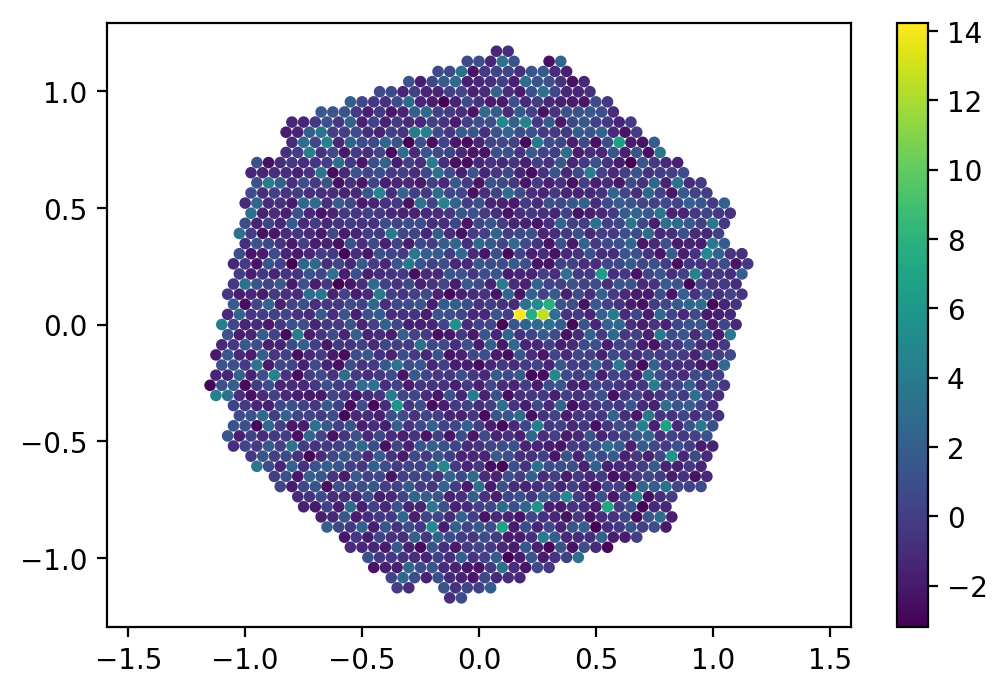

In [23]:
plt.scatter(pixelPos[:,0], pixelPos[:,1], c=all_lst_images[0],s=10)
plt.axis('equal')
plt.colorbar()